# Vinli

**Date**: 0223

In [1]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import TomekLinks
from shapely.geometry import Point, Polygon
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import geopandas as gpd
import dateutil.parser
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import folium
import os


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/jpolanco/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Opening the json file
path = os.path.join(os.getcwd(), "data")
df = pd.read_json(path+'/data.json', lines=True)
df.head(2)

,tripId,vehicleId,start,stop,startPointLat,startPointLon,stopPointLat,stopPointLon,distance,duration,averageLoad,averageMovingSpeed,maxSpeed,averageSpeed,fuelEconomy,hardAccelCount,hardBrakeCount,stopCount,make,model,year,mpg_city,mpg_highway
0,000b2166-c04b-4498-9ceb-ab216d65e68c,479ef4b6-e4de-4f42-93e3-eab290043fd5,2018-03-31T00:35:56.063Z,2018-03-31T00:40:22.891Z,38.245573,-104.559464,38.245120,-104.569932,4121.6699,266828.0,28.654800,66.569199,96,64.262398,29.650999,0,0,1,Toyota,Camry,2003.0,NaN,NaN
1,00111ecb-461e-45c9-b28f-dcede088e163,a05d9b60-0572-49b5-9bde-fc2ee25f4c2f,2018-10-18T02:44:51.015Z,2018-10-18T02:54:27.245Z,34.398947,-118.481282,34.398792,-118.481896,1130.5601,576230.0,26.909599,11.929500,30,7.832700,6.561500,0,0,14,Infiniti,G37,2009.0,NaN,NaN


### Formating the data:

In [4]:
# Formating datetime features
df['start'] = df['start'].apply(dateutil.parser.parse)
df['start_year'] = df['start'].dt.year
df['start_month'] = df['start'].dt.month
df['start_day'] = df['start'].dt.day
df['start_weekday'] = df['start'].dt.day_name()
df['start_Year-Week'] = df['start'].map(lambda dt: dt.strftime('%y-%W'))

df['stop'] = df['stop'].apply(dateutil.parser.parse)
df['stop_year'] = df['stop'].dt.year
df['stop_month'] = df['stop'].dt.month
df['stop_day'] = df['stop'].dt.day
df['stop_weekday'] = df['stop'].dt.day_name()
df['stop_Year-Week'] = df['stop'].map(lambda dt: dt.strftime('%y-%W'))


In [5]:
# Formating coordinates features
df['start_coordinates'] = list(zip(df.startPointLat, df.startPointLon))
df['stop_coordinates'] = list(zip(df.stopPointLat, df.stopPointLon))


In [6]:
# Formating make feature
df['make'] = df['make'].apply(lambda x: None if type(x) != str else x)
df['make'] = df['make'].apply(lambda x: x.upper() if type(x) == str else x)

df.loc[df['make'] == 'HYUNDAI, KIA', 'make'] = "KIA"
df.loc[df['make'] == 'KIA MOTORS CORP', 'make'] = "KIA"
df.loc[df['make'] == 'MERCEDES BENZ', 'make'] = "MERCEDES-BENZ"
df.loc[df['make'] == 'NISSAN, INFINITY', 'make'] = "INFINITI"

# Formating model feature
df['model'] = df['model'].apply(lambda x: x.upper() if type(x) == str else x)


In [7]:
df.head(2)

,tripId,vehicleId,start,stop,startPointLat,startPointLon,stopPointLat,stopPointLon,distance,duration,averageLoad,averageMovingSpeed,maxSpeed,averageSpeed,fuelEconomy,hardAccelCount,hardBrakeCount,stopCount,make,model,year,mpg_city,mpg_highway,start_year,start_month,start_day,start_weekday,start_Year-Week,stop_year,stop_month,stop_day,stop_weekday,stop_Year-Week,start_coordinates,stop_coordinates
0,000b2166-c04b-4498-9ceb-ab216d65e68c,479ef4b6-e4de-4f42-93e3-eab290043fd5,2018-03-31 00:35:56.063000+00:00,2018-03-31 00:40:22.891000+00:00,38.245573,-104.559464,38.245120,-104.569932,4121.6699,266828.0,28.654800,66.569199,96,64.262398,29.650999,0,0,1,TOYOTA,CAMRY,2003.0,NaN,NaN,2018,3,31,Saturday,18-13,2018,3,31,Saturday,18-13,"(38.245573, -104.559464)","(38.24512, -104.569932)"
1,00111ecb-461e-45c9-b28f-dcede088e163,a05d9b60-0572-49b5-9bde-fc2ee25f4c2f,2018-10-18 02:44:51.015000+00:00,2018-10-18 02:54:27.245000+00:00,34.398947,-118.481282,34.398792,-118.481896,1130.5601,576230.0,26.909599,11.929500,30,7.832700,6.561500,0,0,14,INFINITI,G37,2009.0,NaN,NaN,2018,10,18,Thursday,18-42,2018,10,18,Thursday,18-42,"(34.398947, -118.481282)","(34.398792, -118.481896)"


In [8]:
# Exploting data type of the features
pd.DataFrame(df.isnull().sum()).sort_values(by=0, ascending=False).head(5)

,0
mpg_highway,247842
mpg_city,241410
model,45429
year,41817
make,37873


### Data Modelling:

**This excercise'll give me 2 inputs**:
* A Classification Model that will help me to fill in the missing values in the 'make' column
* It'll bring some insights around the importance of some continuous variables in order to classify the 'make' variable

In [9]:
car_make = pd.DataFrame(df['make'].unique()).reset_index()
car_make.columns = ['make_id', 'make']

df_make = df.groupby(['vehicleId','make']).agg({'distance':'median','duration':'median',
                                      'averageLoad':'median',
                                      'averageMovingSpeed':'median'}).reset_index()

df_make = df_make[['make', 'distance', 'duration', 'averageLoad', 'averageMovingSpeed']] 

df_make = df_make.merge(car_make, on='make', how='left')

df_make = df_make[df_make['make'].notna()]

a = pd.DataFrame(df_make['make'].value_counts()).reset_index()
list_1 = list(a[a['make']>=9]['index'])
df_make = df_make[df_make['make'].isin(list_1)]

y = df_make['make_id']
X = df_make.iloc[:,1:-1]

scale= StandardScaler()
X = scale.fit_transform(X)


In [10]:
# Define SMOTE-Tomek Links
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X, y = resample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

rfc = RandomForestClassifier(n_estimators=100, random_state=123)
rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, rfc_predict))
print('--------------------------------------------')
print(classification_report(y_test, rfc_predict))


Accuracy score:  0.7741826761038085
--------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.51      0.56        92
           1       0.78      0.88      0.83       104
           2       0.62      0.70      0.65        92
           4       0.53      0.37      0.44       107
           5       0.66      0.73      0.70        89
           6       0.90      0.85      0.88       109
           7       0.81      0.81      0.81       113
           8       0.77      0.80      0.79        99
           9       0.75      0.79      0.77       113
          10       0.82      0.93      0.87       107
          11       0.64      0.56      0.59       104
          12       0.73      0.76      0.75       109
          13       0.71      0.83      0.77       101
          14       0.76      0.85      0.80        92
          15       0.80      0.80      0.80       113
          17       0.77      0.74      0.76       117


In [11]:
# Feature importance
for score, name in zip(rfc.feature_importances_, df_make.iloc[:,1:].columns):
    print(round(score, 2), name)
    

0.23 distance
0.22 duration
0.29 averageLoad
0.26 averageMovingSpeed


In [12]:
# Save the model to a file
joblib.dump(rfc, 'random_forest_model.joblib')

['random_forest_model.joblib']

### Filling Missing Values:

In [13]:
# Filling Missing Values with the Mode
df['year'] = df['year'].fillna(df['year'].mode()[0], inplace=False)
df['year'] = df['year'].astype(int)


In [14]:
# Filling Missing Values with the median
df['mpg_highway'] = df['mpg_highway'].fillna(df['mpg_highway'].median())
df['mpg_city'] = df['mpg_city'].fillna(df['mpg_city'].median())


In [15]:
# Filling in Make Nulls with the model's output
list_make_NA = df[df['make'].isnull()][['distance', 'duration', 'averageLoad', 'averageMovingSpeed']].index.tolist()

Cls_NA_make = rfc.predict(df[df['make'].isnull()][['distance', 'duration', 'averageLoad', 'averageMovingSpeed']])
Cls_NA_make = pd.DataFrame(Cls_NA_make, columns = ['make_id'])
Cls_NA_make = Cls_NA_make.merge(car_make, on='make_id', how='left')
Cls_NA_make = Cls_NA_make['make'].values

df.iloc[list_make_NA,[18]] = Cls_NA_make


/Users/jpolanco/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [16]:
# Getting the most popular model of each brand
top_model = df[['make','model']].pivot_table(index='make', columns='model', aggfunc='size',
                                             fill_value=0).T

col_l = []
max_index_l = []

for col in top_model.columns:
    max_index = top_model[col].idxmax()
    
    col_l.append(col)
    max_index_l.append(max_index)
    
top_model = pd.DataFrame([col_l,max_index_l]).T
top_model.columns = ['make', 'model_popular']


In [17]:
df = df.merge(top_model, on='make', how='left')
df['model'] = np.where(df['model'].isnull(), df['model_popular'], df['model'])


In [18]:
df = df.drop('model_popular', axis=1)


In [19]:
df.head()

,tripId,vehicleId,start,stop,startPointLat,startPointLon,stopPointLat,stopPointLon,distance,duration,averageLoad,averageMovingSpeed,maxSpeed,averageSpeed,fuelEconomy,hardAccelCount,hardBrakeCount,stopCount,make,model,year,mpg_city,mpg_highway,start_year,start_month,start_day,start_weekday,start_Year-Week,stop_year,stop_month,stop_day,stop_weekday,stop_Year-Week,start_coordinates,stop_coordinates
0,000b2166-c04b-4498-9ceb-ab216d65e68c,479ef4b6-e4de-4f42-93e3-eab290043fd5,2018-03-31 00:35:56.063000+00:00,2018-03-31 00:40:22.891000+00:00,38.245573,-104.559464,38.245120,-104.569932,4121.6699,266828.0,28.654800,66.569199,96,64.262398,29.650999,0,0,1,TOYOTA,CAMRY,2003,19.0,26.0,2018,3,31,Saturday,18-13,2018,3,31,Saturday,18-13,"(38.245573, -104.559464)","(38.24512, -104.569932)"
1,00111ecb-461e-45c9-b28f-dcede088e163,a05d9b60-0572-49b5-9bde-fc2ee25f4c2f,2018-10-18 02:44:51.015000+00:00,2018-10-18 02:54:27.245000+00:00,34.398947,-118.481282,34.398792,-118.481896,1130.5601,576230.0,26.909599,11.929500,30,7.832700,6.561500,0,0,14,INFINITI,G37,2009,19.0,26.0,2018,10,18,Thursday,18-42,2018,10,18,Thursday,18-42,"(34.398947, -118.481282)","(34.398792, -118.481896)"
2,002f904b-e932-417e-a935-783f6bcf6e5a,4fc04634-d3bc-4007-b39c-35496431dfd4,2018-07-14 21:03:51.911000+00:00,2018-07-14 21:11:20.505000+00:00,0.000000,0.000000,0.000000,0.000000,3853.3401,448594.0,33.298698,43.328300,73,32.471802,25.391600,0,0,5,TOYOTA,HIGHLANDER HYBRID,2007,28.0,25.0,2018,7,14,Saturday,18-28,2018,7,14,Saturday,18-28,"(0.0, 0.0)","(0.0, 0.0)"
3,0031915a-8767-4b38-b8de-d605a408f2e9,516ec7ab-9948-4ebb-afa8-98a5d2978dd6,2018-02-01 21:29:18.480000+00:00,2018-02-01 21:48:27.590000+00:00,33.178182,-96.884684,33.182595,-96.878665,9374.1201,1149110.0,39.960800,46.684101,84,29.737200,14.277000,0,0,16,FORD,F-150,2009,14.0,18.0,2018,2,1,Thursday,18-05,2018,2,1,Thursday,18-05,"(33.178182, -96.884684)","(33.182595, -96.878665)"
4,003d8be7-597f-4c17-8fab-fe84862e6add,253f70f6-0267-4503-b119-ab07dd41ebe1,2018-09-15 15:56:22.588000+00:00,2018-09-15 16:32:30.512000+00:00,38.837413,-94.406578,38.794731,-94.493225,14221.2500,2167924.0,0.000000,54.279701,93,42.668098,0.000000,0,0,4,HYUNDAI,ELANTRA,2018,19.0,26.0,2018,9,15,Saturday,18-37,2018,9,15,Saturday,18-37,"(38.837413, -94.406578)","(38.794731, -94.493225)"


### Answering some questions:

#### Q1

**How many total trips are present?**

In [20]:
print("# Unique Trip ID: ", str(round(df['tripId'].nunique()/1000,1))+"K")

# Unique Trip ID:  741.6K


**How many total vehicles?**

In [21]:
print("# Unique Vehicle ID: ", str(round(df['vehicleId'].nunique()/1000,1))+"K")

# Unique Vehicle ID:  4.1K


**What date range is covered by this sample?**

In [22]:
print("Min date: ", df['start'].dt.date.min(), " - ", "Max date: ",df['stop'].dt.date.max())

Min date:  2018-01-01  -  Max date:  2019-01-25


#### Q2

**What is the distribution of vehicle make, model and year?**

In [23]:
df_make = pd.DataFrame(df['make'].value_counts()).reset_index()
df_make.columns = ['Make','Counts']

df_make = df_make.sort_values(by='Counts', ascending = False)
df_make['%_Count'] = round((df_make['Counts']/df_make['Counts'].sum())*100,1)
df_make['%_Acum_Count'] = df_make['%_Count'].cumsum()

# Top 10
df_make.head(10)


,Make,Counts,%_Count,%_Acum_Count
0,FORD,87871,11.8,11.8
1,JEEP,86603,11.7,23.5
2,HONDA,81049,10.9,34.4
3,TOYOTA,79428,10.7,45.1
4,NISSAN,76202,10.3,55.4
5,DODGE,51753,7.0,62.4
6,CHRYSLER,29748,4.0,66.4
7,CHEVROLET,27069,3.7,70.1
8,LEXUS,19079,2.6,72.7
9,SUBARU,17149,2.3,75.0


In [24]:
df_model = pd.DataFrame(df['model'].value_counts()).reset_index()
df_model.columns = ['Model','Counts']

df_model = df_model.sort_values(by='Counts', ascending = False)
df_model['%_Counts'] = round((df_model['Counts']/df_model['Counts'].sum())*100,1)
df_model['%_Acum_Count'] = df_model['%_Counts'].cumsum()

# Top 10
df_model.head(10)


,Model,Counts,%_Counts,%_Acum_Count
0,GRAND CHEROKEE,46098,6.2,6.2
1,ALTIMA,41113,5.5,11.7
2,F-150,28288,3.8,15.5
3,DURANGO,22679,3.1,18.6
4,CR-V,20263,2.7,21.3
5,WRANGLER,17620,2.4,23.7
6,PACIFICA,16297,2.2,25.9
7,CAMRY,14575,2.0,27.9
8,CIVIC,13493,1.8,29.7
9,EXPLORER,13346,1.8,31.5


In [25]:
# Considering the orinal distribution with NAs
df_year = pd.read_json(path+'/data.json', lines=True)

df_year = pd.DataFrame(df_year['year'].value_counts(dropna=False)).reset_index()
df_year.columns = ['year','Counts']

df_year = df_year.sort_values(by='Counts', ascending = False)
df_year['%_Counts'] = round((df_year['Counts']/df_year['Counts'].sum())*100,2)
df_year['Acum_Count'] = df_year['%_Counts'].cumsum()

df_year['year'] = df_year['year'].fillna(-1)
df_year['year'] = df_year['year'].astype(int)

# Top 10
df_year.head(10)


,year,Counts,%_Counts,Acum_Count
0,2018,107033,14.43,14.43
1,2017,92337,12.45,26.88
2,2015,64360,8.68,35.56
3,2013,58249,7.85,43.41
4,2016,51971,7.01,50.42
5,-1,41817,5.64,56.06
6,2011,39747,5.36,61.42
7,2010,39366,5.31,66.73
8,2006,38317,5.17,71.90
9,2007,38089,5.14,77.04


#### Q3

**Can you find any interesting relationships between make / model versus other fields in
the data set?**

Data Modelling section

#### Q4

We have missing data in a few fields, including vehicle year. Talk us through how you
might deal with this.

* **Year**: Fill NAs using the Mode of the column.
* **mpg_highway**: Fill NAs using the Median of the column.
* **mpg_city**: Fill NAs using the Median of the column.
* **model**: Fill NAs using the Mode of the make.
* **make**: Fill NAs using a Classifier.

### Geo-data in the US:

**Shape File Source**: https://hub.arcgis.com/datasets/1b02c87f62d24508970dc1a6df80c98e_0/explore

In [26]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.startPointLon, df.startPointLat))

gdf = gdf.set_crs(epsg=4326, allow_override=True)

In [27]:
cities = gpd.read_file(os.path.join(os.getcwd(), "data", "States_shapefile", "States_shapefile.shp"))
cities = cities.set_crs(epsg=4326, allow_override=True)

In [28]:
df_join = gpd.sjoin(gdf, cities, how='inner', op='within')
df_join.head()

/Users/jpolanco/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,tripId,vehicleId,start,stop,startPointLat,startPointLon,stopPointLat,stopPointLon,distance,duration,averageLoad,averageMovingSpeed,maxSpeed,averageSpeed,fuelEconomy,hardAccelCount,hardBrakeCount,stopCount,make,model,year,mpg_city,mpg_highway,start_year,start_month,start_day,start_weekday,start_Year-Week,stop_year,stop_month,stop_day,stop_weekday,stop_Year-Week,start_coordinates,stop_coordinates,geometry,index_right,FID,Program,State_Code,State_Name,Flowing_St,FID_1
0,000b2166-c04b-4498-9ceb-ab216d65e68c,479ef4b6-e4de-4f42-93e3-eab290043fd5,2018-03-31 00:35:56.063000+00:00,2018-03-31 00:40:22.891000+00:00,38.245573,-104.559464,38.245120,-104.569932,4121.66990,266828.0,28.654800,66.569199,96,64.262398,29.650999,0,0,1,TOYOTA,CAMRY,2003,19.0,26.0,2018,3,31,Saturday,18-13,2018,3,31,Saturday,18-13,"(38.245573, -104.559464)","(38.24512, -104.569932)",POINT (-104.55946 38.24557),5,6,ECOMAP,CO,COLORADO,F,924
10,0076bac2-50e5-4f4e-b03c-7eaae21d9b85,1d13baca-6ec6-42fa-9468-ca5bc1f8c103,2018-11-10 04:08:01.758000+00:00,2018-11-10 04:20:46.858000+00:00,39.903232,-105.053318,39.856753,-105.041393,7991.12010,765100.0,21.735800,48.169399,70,38.813599,19.454700,0,0,4,BMW,X4,2016,19.0,27.0,2018,11,10,Saturday,18-45,2018,11,10,Saturday,18-45,"(39.903232, -105.053318)","(39.856753, -105.041393)",POINT (-105.05332 39.90323),5,6,ECOMAP,CO,COLORADO,F,924
27,00eec4be-0663-4030-9438-24e5bb98320c,479ef4b6-e4de-4f42-93e3-eab290043fd5,2018-02-26 21:16:21.042000+00:00,2018-02-26 22:00:21.236000+00:00,38.273545,-104.610296,38.271567,-104.613971,4711.95020,2640194.0,19.775801,21.056000,44,6.411500,9.724500,0,0,12,TOYOTA,CAMRY,2003,19.0,26.0,2018,2,26,Monday,18-09,2018,2,26,Monday,18-09,"(38.273545, -104.610296)","(38.271567, -104.613971)",POINT (-104.61030 38.27354),5,6,ECOMAP,CO,COLORADO,F,924
67,024c637b-44aa-4afb-9ad2-571635d33a97,36f375e0-76ec-4ad0-ada9-651c2581732c,2018-01-07 16:28:14.611000+00:00,2018-01-07 16:30:27.841000+00:00,39.740024,-104.963316,39.740146,-104.963264,456.67001,133230.0,30.435499,26.147499,51,14.115000,7.537500,0,0,4,AUDI,ALLROAD,2014,20.0,27.0,2018,1,7,Sunday,18-01,2018,1,7,Sunday,18-01,"(39.740024, -104.963316)","(39.740146, -104.963264)",POINT (-104.96332 39.74002),5,6,ECOMAP,CO,COLORADO,F,924
122,0432f996-63c0-4dba-a804-c04b385060dd,d85e4d58-9698-46f2-8c20-7fe196e47c2f,2018-12-21 02:04:27.477000+00:00,2018-12-21 02:26:55.798000+00:00,38.624958,-108.096820,38.617413,-108.106183,22651.96100,1348321.0,20.823200,75.823799,107,72.699203,0.000000,0,0,3,DODGE,RAM PICKUP 2500,2005,19.0,26.0,2018,12,21,Friday,18-51,2018,12,21,Friday,18-51,"(38.624958, -108.09682)","(38.617413, -108.106183)",POINT (-108.09682 38.62496),5,6,ECOMAP,CO,COLORADO,F,924


In [29]:
# Defining the geometry
geometry = [Point(xy) for xy in zip(df_join["startPointLat"],df_join["stopPointLat"])]

# Type of format for the lat and lng
crs = {'init':'epsg:4326'}

# Transforming the DataFrame to a GeoDataFrame
geo_df = gpd.GeoDataFrame(df_join, crs=crs, geometry=geometry).sort_values(by='distance',ascending=False)

# Only mapping the Top 100 in terms of Distance in the US
geo_df = geo_df.head(100)

# Starting point
m = folium.Map(location=[40,-105], zoom_start=4)

# Plotting all the different locations
for i in range(len(geo_df)):
    folium.Marker(location=(geo_df.iloc[i,4], geo_df.iloc[i,5])).add_to(m)

m.save(os.path.join(os.getcwd(), "top_100_distance_USA.html"))


/Users/jpolanco/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


**Fun Fact**: 1/4 of the top 100 cars that traveled the most distance were from Floridad. Among the previous cases, Miami is the most common city.

In [30]:
top_100 = pd.DataFrame(geo_df['State_Name'].value_counts()).reset_index()
top_100.columns = ['State', 'Counts']
top_100['%'] = round((top_100['Counts']/top_100['Counts'].sum())*100,2)
top_100.head(5)

,State,Counts,%
0,FLORIDA,26,26.0
1,TEXAS,13,13.0
2,NEW YORK,7,7.0
3,MONTANA,5,5.0
4,CALIFORNIA,4,4.0


## US Trips Analysis

In [31]:
df_state = pd.DataFrame(df_join['State_Name'].value_counts()).reset_index()
df_state.columns = ['State','Counts']

df_state = df_state.sort_values(by='Counts', ascending = False)
df_state['Counts'] = round((df_state['Counts']/df_state['Counts'].sum())*100,2)
df_state['Acum_Count'] = df_state['Counts'].cumsum()
df_state_70 = df_state[df_state['Acum_Count']<=70]
df_state_70

,State,Counts,Acum_Count
0,FLORIDA,20.07,20.07
1,TEXAS,14.39,34.46
2,CALIFORNIA,11.25,45.71
3,UTAH,6.66,52.37
4,GEORGIA,3.70,56.07
5,NEW YORK,3.05,59.12
6,ILLINOIS,2.89,62.01
7,WASHINGTON,2.80,64.81
8,VIRGINIA,2.41,67.22
9,NORTH CAROLINA,2.25,69.47


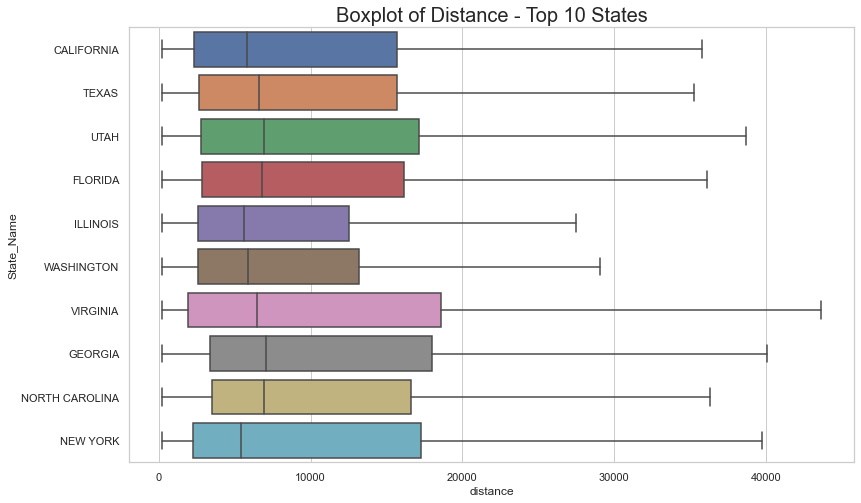

In [32]:
# Boxplot (with no outliers)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(13,8))

ax = sns.boxplot(x="distance", y="State_Name", data=df_join[df_join['State_Name'].isin(list(df_state_70['State']))], 
                showfliers=False)

plt.title('Boxplot of Distance - Top 10 States', 
          fontdict = {'fontsize' : 20})

plt.show()

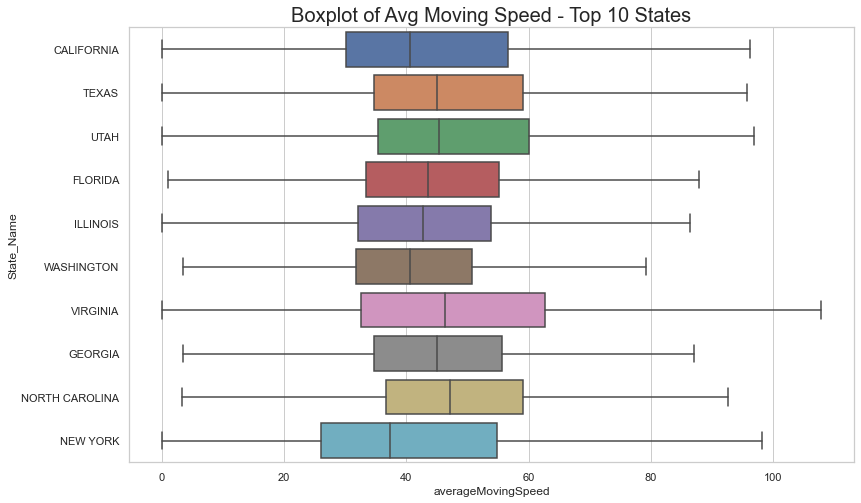

In [33]:
# Boxplot (with no outliers)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(13,8))

ax = sns.boxplot(x="averageMovingSpeed", y="State_Name", data=df_join[df_join['State_Name'].isin(list(df_state_70['State']))], 
                showfliers=False)

plt.title('Boxplot of Avg Moving Speed - Top 10 States', 
          fontdict = {'fontsize' : 20})

plt.show()

In [ ]:
# Getting the dependencies
